In [30]:
import requests
from tqdm import tqdm

## Объявление констант

In [31]:
TOKEN = "f185ecc4f185ecc4f185ecc42cf296de11ff185f185ecc49599ca335d0fd6a7c8d49da4"
first_group = 'buh.mephi'
second_group = 'icismephi'
BASIC_RESPONSE = 'https://api.vk.com/method/'
V = 5.131

# Получение списков групп и их сравнение

### Запрос к API. Метод getMembers

In [32]:
def get_member(group_id, offset=0):
    response = requests.get(BASIC_RESPONSE + 'groups.getMembers', params={
            'access_token': TOKEN,
            'v': V,
            'offset': offset, 
            'sort':'id_desc',
            'group_id': group_id
        }).json()
    
    if 'response' in response:
        return response['response']

### Создание класса Группа

In [33]:
class Group:
    def __init__(self, group_name):
        self.group_name = group_name
        self.members = []
        self.posts = []
        
    def set_members(self):
        count = get_member(self.group_name)['count'] 

        if count == 0:
            return members_list 
        # Вычитаем остаток от деления на 1000, чтобы получить количество в тысячах 
        max_offset = count - count % 1000

        for offset in range(0, max_offset+1, 1000):
            offset_members = get_member(self.group_name, offset)
            
            if offset_members is not None:
                self.members.extend(offset_members['items']) 

### Инициализация объектов класса

In [34]:
iftes_group = Group(first_group)
icis_group = Group(second_group)

In [35]:
iftes_group.set_members()
icis_group.set_members()

# Построение социального графа

### Запрос к API. Метод friends.get

In [38]:
def get_friends(user_id):
    response = requests.get(BASIC_RESPONSE + 'friends.get', params={
        'access_token': TOKEN,
        'v': V,
        'user_id': user_id
    }).json()
    
    if 'error' in response:
        return set()
    else: 
        return set(response['response']['items'])

### Получаем данные для графа

In [39]:
from tqdm import tqdm

In [40]:
def set_graph_data(members):
    graph = {}
    for member in tqdm(members):
        friends = get_friends(member)
        common_friends = friends & members
        graph[member] = list(common_friends)
    
    return graph

In [12]:
graph_iftes = set_graph_data(set(iftes_group.members))

100%|██████████████████████████████████████████████████████████████████████████████| 1933/1933 [03:22<00:00,  9.56it/s]


In [41]:
graph_icis = set_graph_data(set(icis_group.members))

100%|██████████████████████████████████████████████████████████████████████████████| 3257/3257 [04:02<00:00, 13.44it/s]


## Построение графа

In [42]:
import networkx as nx

In [43]:
g_iftes = nx.DiGraph(graph_iftes)
g_icis = nx.DiGraph(graph_icis)

## Функции распределения степеней узлов для обоих сообществ

In [45]:
import matplotlib.pyplot as plt

In [46]:
def get_degrees(g):
    return [val for (node, val) in g.degree()]

#### Распределение степеней узлов первого сообщества

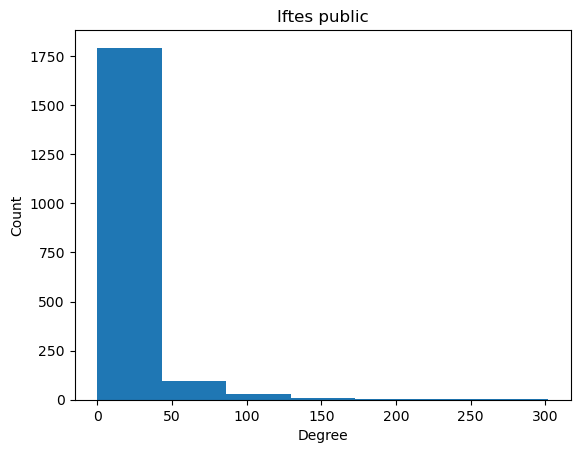

In [57]:
degree_iftes = get_degrees(g_iftes)

plt.hist(degree_iftes,bins = 7)
plt.ylabel("Count")
plt.xlabel("Degree")
plt.title("Iftes public")
plt.show()

#### Распределение степеней узлов второго сообщества

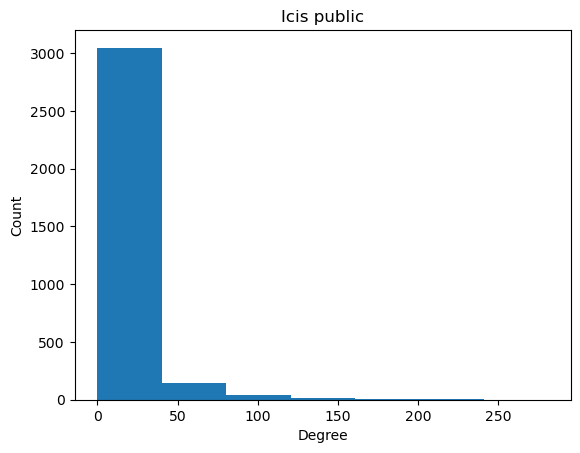

In [58]:
degree_icis = get_degrees(g_icis)

plt.hist(degree_icis,bins = 7)
plt.ylabel("Count")
plt.xlabel("Degree")
plt.title("Icis public")
plt.show()

## 

## Вычисление кластерных коэффициентов обоих сообществ 

In [59]:
coefficient_iftes = nx.average_clustering(g_iftes)
print(f"Кластерный коэффициент для группы iftes {coefficient_iftes}")

Кластерный коэффициент для группы iftes 0.2566829428531108


In [61]:
coefficient_icis = nx.average_clustering(g_icis)
print(f"Кластерный коэффициент для группы icis {coefficient_icis}")

Кластерный коэффициент для группы icis 0.16353045916476072


## Вычисление средней длины пути обоих графов

In [66]:
def average_graph_length_way(graph):
    ways = [] 
    graph_undirect = graph.to_undirected()
    for component in nx.connected_components(graph_undirect):
        length = nx.average_shortest_path_length(graph_undirect.subgraph(component))
        if length != 0:
            ways.append(length)
    return sum(ways) / len(ways)

In [67]:
print(f"Средняя длина пути для графа iftes {average_graph_length_way(g_iftes)}")

Средняя длина пути для графа iftes 1.6709520492213885


In [68]:
print(f"Средняя длина пути для графа icis {average_graph_length_way(g_icis)}")

Средняя длина пути для графа icis 1.1746139632986978


## Соотнесение моделей графов

### Средняя длина пути

In [76]:
import numpy as np

#### модель Random

In [73]:
def average_length_way_random(g, degrees):
    average_k = (sum(degrees)/len(degrees))
    return np.log(len(g)) / np.log(average_k)

#### модель BA

In [80]:
def average_length_way_BA(g):
    return np.log(len(g)) / np.log(np.log(len(g)))

#### модель WS

In [81]:
def average_length_way_WS(g):
    return np.log(len(g))

In [84]:
def calculate_average_length_way(g, degrees, name): 
    random = average_length_way_random(g, degrees)
    BA = average_length_way_BA(g)
    WS = average_length_way_WS(g)
    print(f"Для графа сообщества {name} получены следующие моделируемые коэффициенты L:")
    print(f"Random model: {random}")
    print(f"BA model: {BA}")
    print(f"WS model: {WS}")
    print(f"L графа: {average_graph_length_way(g)}")

### Исследование первого сообщества

In [85]:
calculate_average_length_way(g_iftes, degree_iftes, 'iftes')

Для графа сообщества iftes получены следующие моделируемые коэффициенты L:
Random model: 2.8666046994416967
BA model: 3.7389690758600396
WS model: 7.566828479208331
L графа: 1.6709520492213885


In [89]:
C_random = (sum(degree_iftes)/len(degree_iftes)) / len(g_iftes)
print(f"C для Random model {C_random}, C графа: {coefficient_iftes}")

C для Random model 0.007246910134085769, C графа: 0.2566829428531108


In [94]:
C_BA = len(g_iftes) ** -0.75
print(f"C для BA model {C_BA}, C графа: {coefficient_iftes}")

C для BA model 0.0034302526576103416, C графа: 0.2566829428531108


#### Распределение степеней в графе сообщества iftes наиболее сопоставима c Random model

### Исследование второго сообщества

In [92]:
calculate_average_length_way(g_icis, degree_icis, 'icis')

Для графа сообщества icis получены следующие моделируемые коэффициенты L:
Random model: 3.414691393253255
BA model: 3.8692904229747143
WS model: 8.088561805276234
L графа: 1.1746139632986978


In [93]:
C_random = (sum(degree_icis)/len(degree_icis)) / len(g_icis)
print(f"C для Random model {C_random}, C графа: {coefficient_icis}")

C для Random model 0.0032803392970752678, C графа: 0.16353045916476072


In [95]:
C_BA = len(g_icis) ** -0.75
print(f"C для BA model {C_BA}, C графа: {coefficient_icis}")

C для BA model 0.002319458898395755, C графа: 0.16353045916476072


#### Распределение степеней в графе сообщества icis наиболее сопоставима c Random model